# <span style="color:red">QPM: Assigment 2</span>

###  LIN Christine, MUSEUX Célia and YANG Hexuan 

Financial Engineering - Quantitative Portfolio Management

**Due date :** 06/11/2023 9am

**Ressource:** Tidy finance website

## <span style="color:green">Preliminary step</span>

In [1]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from tabulate import tabulate
from scipy.stats import norm

## <span style="color:green">Question 1 of Assigment 2</span>

We download daily stock prices for FAANG stocks (Facebook/Meta, Amazon, Apple, Netflix, Google/Alphabet) from January 2015 until December 2020, directly from the data provider Yahoo!Finance. To download the data, you can use the function `yf.download()`.

In [2]:
symbols = ("META","AMZN","AAPL","NFLX","GOOG")
index_prices = (yf.download(tickers=symbols, 
                            start="2015-01-01",
                            end="2020-12-31",
                            progress=False)
  .melt(ignore_index=False, 
        var_name=["variable", "symbol"])
  .reset_index()
  .pivot(index=["Date", "symbol"], 
         columns="variable", 
         values="value")
  .reset_index()
  .rename(columns = {"Date": "date", 
                     "Open": "open", 
                     "High": "high", 
                     "Low": "low",
                     "Close": "close", 
                     "Adj Close": "adjusted", 
                     "Volume": "volume"
                    })
)

We can visualize the time series of adjusted daily prices for FAANG stocks.

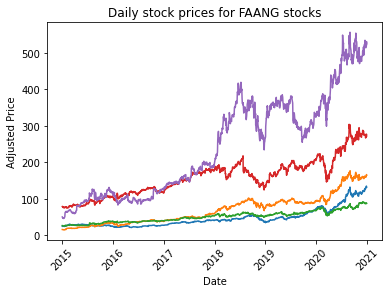

In [3]:
fig, ax = plt.subplots()
for symbol in index_prices['symbol'].unique():
    subset = index_prices[index_prices['symbol'] == symbol]
    ax.plot(subset['date'], subset['adjusted'], label=symbol)
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Price')
ax.set_title('Daily stock prices for FAANG stocks')

plt.xticks(rotation=45)
plt.show()

## <span style="color:green">Question 2 of Assigment 2</span>

We want to compute the first and second moments of stock returns for each of these stocks (i.e., their means, variances, and covariances).

### STEP 1: we calculate the returns

Instead of analyzing prices, we compute daily net returns defined as 
r<sub>t</sub> = p<sub>t</sub>/p<sub>t-1</sub> -1 , where $pt$ is the adjusted price on day $t$. In that context, we use the function `pct_change()`which computes the percentage change.

In [4]:
all_returns = (index_prices
  .assign(ret = lambda x: x.groupby("symbol")["adjusted"].pct_change())
  .get(["symbol", "date", "ret"])
  .dropna(subset="ret")
)

The resulting data frame contains three columns, where the last contains the daily returns (ret). Note that the first entry naturally contains a missing value (NaN) because there is no previous price.

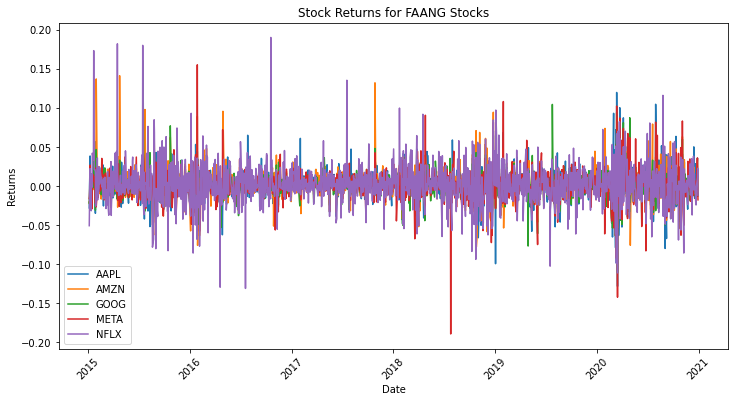

In [5]:
symbols = all_returns['symbol'].unique()
fig, ax = plt.subplots(figsize=(12, 6))
for symbol in symbols:
    subset = all_returns[all_returns['symbol'] == symbol]
    ax.plot(subset['date'], subset['ret'], label=symbol)
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.set_title('Stock Returns for FAANG Stocks')
ax.legend(loc='best')
plt.xticks(rotation=45)

plt.show()

The few lines of code below compute the summary statistics for individual groups of data defined by year. The function `groupby("symbol")`is the key to aggregating the time series into symbol-specific variables of interest. The summary statistics, therefore, allow an eyeball analysis of the time-series dynamics of the return distribution.

In [6]:
(all_returns
  .groupby("symbol")["ret"]
  .describe()
  .round(3)
)

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,1509.0,0.001,0.019,-0.129,-0.006,0.001,0.010,0.120
AMZN,1509.0,0.002,0.020,-0.079,-0.007,0.001,0.011,0.141
GOOG,1509.0,0.001,0.017,-0.111,-0.006,0.001,0.009,0.161
META,1509.0,0.001,0.020,-0.190,-0.007,0.001,0.011,0.155
NFLX,1509.0,0.002,0.027,-0.131,-0.011,0.000,0.015,0.190


### STEP 2: calculate their means, variances, covariances

In [7]:
grouped_returns = all_returns.groupby('symbol')
mean_returns = grouped_returns['ret'].mean()
variance_returns = grouped_returns['ret'].var()
cov_matrix = all_returns.pivot_table(index='date', columns='symbol', values='ret', aggfunc='first').cov()

To have more readable results, we use a formatted table (tabulate)

In [8]:
table = []
table.append(['Stock', 'Mean Return', 'Variance'])
for symbol in symbols:
    table.append([symbol, mean_returns[symbol], variance_returns[symbol]])
formatted_table = tabulate(table, tablefmt="pipe", headers="firstrow")

print("\033[1mMeans and Variances:\033[0m")
print(formatted_table)

Means and Variances:
| Stock   |   Mean Return |    Variance |
|:--------|--------------:|------------:|
| AAPL    |   0.00128899  | 0.000348616 |
| AMZN    |   0.00175748  | 0.000381188 |
| GOOG    |   0.000939359 | 0.000287841 |
| META    |   0.0010266   | 0.000402929 |
| NFLX    |   0.00191444  | 0.000715126 |


In [9]:
print("\033[1mCovariance Matrix:\033[0m")
cov_matrix

Covariance Matrix:


symbol,AAPL,AMZN,GOOG,META,NFLX
symbol,,,,,
AAPL,0.000349,0.000202,0.000192,0.000216,0.000206
AMZN,0.000202,0.000381,0.000216,0.000235,0.000275
GOOG,0.000192,0.000216,0.000288,0.000228,0.000216
META,0.000216,0.000235,0.000228,0.000403,0.000238
NFLX,0.000206,0.000275,0.000216,0.000238,0.000715


## <span style="color:green">Question 3 of Assigment 2</span>

We have to compute the skewness and excess kurtosis for the returns for each of these stocks. Do the daily stock returns have a Normal distribution?

### STEP 1: we calculate the skewness and excess kurtosis

In [10]:
skewness = all_returns.groupby('symbol')['ret'].apply(skew)
excess_kurtosis = all_returns.groupby('symbol')['ret'].apply(kurtosis, fisher=True)

results_df = pd.DataFrame({'Stock': symbols, 'Skewness': skewness, 'Excess Kurtosis': excess_kurtosis})
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

+-------+----------------------+--------------------+
| Stock |       Skewness       |  Excess Kurtosis   |
+-------+----------------------+--------------------+
| AAPL  | -0.08290158172829044 | 6.5844586059071535 |
| AMZN  |  0.7587516969062637  | 7.1718217015716235 |
| GOOG  |  0.5173185926239515  | 10.394846233630826 |
| META  | -0.3296133036154537  | 11.997573505080197 |
| NFLX  |  0.6813630748238344  | 7.322441761223166  |
+-------+----------------------+--------------------+


### STEP 2: Normal distibution ?
We now want to know if our returns follow a normal distribution. To do this, we will compare the skewness and the excess kurtosis of our daily returns with those of a normal distribution (skewness equal to 0 and excess kurtosis equal to 3).

We can have two similar approach:

- 1. consider the absolute value of skewness and excess kurosis and tolerate a deviation from the curve of a normal distribution. If the deviation is small, then we consider that our returns **approximately** follow a normal distribution.

- 2. consider that our returns follow a normal distribution only if skewness = 0 and excess kurtosis = 3.

In [11]:
#Approach 1
for symbol in symbols:
    if abs(skewness[symbol]) < 0.5 and abs(excess_kurtosis[symbol] -3) < 0.5:
        print(f"The returns for {symbol} approximately follow a normal distribution.")
    else:
        print(f"The returns for {symbol} do not follow a normal distribution.")

The returns for AAPL do not follow a normal distribution.
The returns for AMZN do not follow a normal distribution.
The returns for GOOG do not follow a normal distribution.
The returns for META do not follow a normal distribution.
The returns for NFLX do not follow a normal distribution.


In [12]:
#Approach 2
for symbol in symbols:
    if skewness[symbol] == 0 and excess_kurtosis[symbol] == 3:
        print(f"The returns for {symbol} follow a normal distribution.")
    else:
        print(f"The returns for {symbol} do not follow a normal distribution.")

The returns for AAPL do not follow a normal distribution.
The returns for AMZN do not follow a normal distribution.
The returns for GOOG do not follow a normal distribution.
The returns for META do not follow a normal distribution.
The returns for NFLX do not follow a normal distribution.


In order to visualize it, we can plot the distibution of a stock (let's say META) againt the Normal distribution

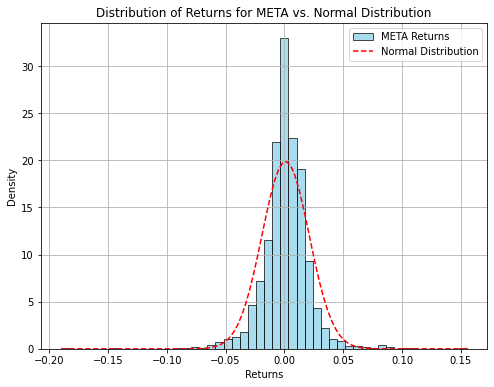

In [13]:
meta_returns = all_returns[all_returns['symbol'] == "META"]["ret"].dropna()
mean_return = meta_returns.mean()
std_deviation = meta_returns.std()
x = np.linspace(meta_returns.min(), meta_returns.max(), 100)
plt.figure(figsize=(8, 6))
plt.hist(meta_returns, bins=50, edgecolor='k',density=True, alpha=0.7, color='skyblue', label='META Returns')
plt.plot(x, norm.pdf(x, loc=mean_return, scale=std_deviation), 'r--', label='Normal Distribution')
plt.title('Distribution of Returns for META vs. Normal Distribution')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.grid(True)
plt.legend()

plt.show()

<span style="color:red">--> We found strong evidence against the assumption that the daily returns follow a normal
distribution both numerically and graphically</span>